In [ ]:

# ==========================
# 1. Cargar librerías
# ==========================
!pip install mlxtend

import pandas as pdpd4
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.impute import SimpleImputer

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [ ]:
#Importar Dataset
import kagglehub

path = kagglehub.dataset_download("arnavvvvv/pokemon-pokedex")
print("Path to dataset files:", path)


Path to dataset files: /kaggle/input/pokemon-pokedex


In [ ]:
csv_path = "/kaggle/input/pokemon-pokedex/Pokemon.csv"

# Carga el DataFrame

df = pd.read_csv(csv_path)
pd.set_option('display.max_columns', None)  # Muestra todas las columnas
pd.set_option('display.width', 1000)        # Ajusta el ancho total
df_ori = df.copy()

# Muestra los primeros registros
print("Primeros 15 registros:")
print(df.head(15))
print("********************")
print("informacion:")
print(df.info())
print("********************")
print("datos")
print(df.describe())
print("********************")


Primeros 15 registros:
     #                       Name Type 1  Type 2  Total  HP  Attack  Defense  Sp. Atk  Sp. Def  Speed  Generation  Legendary
0    1                  Bulbasaur  Grass  Poison    318  45      49       49       65       65     45           1      False
1    2                    Ivysaur  Grass  Poison    405  60      62       63       80       80     60           1      False
2    3                   Venusaur  Grass  Poison    525  80      82       83      100      100     80           1      False
3    3      VenusaurMega Venusaur  Grass  Poison    625  80     100      123      122      120     80           1      False
4    4                 Charmander   Fire     NaN    309  39      52       43       60       50     65           1      False
5    5                 Charmeleon   Fire     NaN    405  58      64       58       80       65     80           1      False
6    6                  Charizard   Fire  Flying    534  78      84       78      109       85    100 

In [ ]:
#Ajustes de dataset
df = df[~df['Name'].str.contains(r'Mega\s', regex=True)]
df = df[~df['Name'].str.contains(r'Primal\s', regex=True)]
df = df[~df['Name'].str.contains(r'Zygarde\s', regex=True)]

ultra_beasts = [
    "Buzzwole", "Pheromosa", "Xurkitree", "Celesteela", "Kartana", "Guzzlord",
    "Nihilego", "Poipole", "Naganadel", "Stakataka", "Blacephalon"
]

# Se asigna clasificacion de legendario a Ultra Bestias
df.loc[df["Name"].isin(ultra_beasts), "Legendary"] = True

# Se corrigen tipos
df.loc[df["Name"] == "Scovillain", "Type_1"] = "Grass"
df.loc[df["Name"] == "Snom", "Type_1"] = "Ice"
df.loc[df["Name"] == "Arctovish", "Type_2"] = "Ice"
df.loc[df["Name"] == "Wimpod", "Type_1"] = "Bug"

df = df.loc[:, ~df.columns.duplicated()]
print(df.columns.tolist())
print(df[df["Name"].isin(ultra_beasts)][["Name", "Legendary"]])
print("********************")
print("Primeros registros actualizados:")
print(df.head(25))
print(df.info())
print("********************")


['#', 'Name', 'Type 1', 'Type 2', 'Total', 'HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'Generation', 'Legendary', 'Type_1', 'Type_2']
            Name  Legendary
871     Nihilego       True
872     Buzzwole       True
873    Pheromosa       True
874    Xurkitree       True
875   Celesteela       True
876      Kartana       True
877     Guzzlord       True
881      Poipole       True
882    Naganadel       True
883    Stakataka       True
884  Blacephalon       True
********************
Primeros registros actualizados:
     #        Name    Type 1  Type 2  Total  HP  Attack  Defense  Sp. Atk  Sp. Def  Speed  Generation  Legendary Type_1 Type_2
0    1   Bulbasaur     Grass  Poison    318  45      49       49       65       65     45           1      False    NaN    NaN
1    2     Ivysaur     Grass  Poison    405  60      62       63       80       80     60           1      False    NaN    NaN
2    3    Venusaur     Grass  Poison    525  80      82       83      100      10

In [ ]:
# ==========================
# 2. Exploración y limpieza
# ==========================
# Ver columnas disponibles
print(df.columns)

# Renombrar columnas si tienen espacios o caracteres inconsistentes
df.columns = df.columns.str.strip().str.replace(' ', '_')

# Eliminar columnas irrelevantes para análisis estadístico
df_clean = df.drop(columns=['#', 'Name'])

# Revisar nulos
print(df_clean.isnull().sum())

# Imputar tipos faltantes como 'None' o 'Unknown'
df_clean['Type_2'] = df_clean['Type_2'].fillna('NaN')

print("Primeros 5 registros:")
print(df.head(15))
print("********************")
print("informacion:")
print(df.info())
print("********************")
print("datos")
print(df.describe())


Index(['#', 'Name', 'Type 1', 'Type 2', 'Total', 'HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'Generation', 'Legendary', 'Type_1', 'Type_2'], dtype='object')
Type_1           0
Type_2         502
Total            0
HP               0
Attack           0
Defense          0
Sp._Atk          0
Sp._Def          0
Speed            0
Generation       0
Legendary        0
Type_1        1051
Type_2        1053
dtype: int64
Primeros 5 registros:
     #        Name Type_1  Type_2  Total  HP  Attack  Defense  Sp._Atk  Sp._Def  Speed  Generation  Legendary Type_1 Type_2
0    1   Bulbasaur  Grass  Poison    318  45      49       49       65       65     45           1      False    NaN    NaN
1    2     Ivysaur  Grass  Poison    405  60      62       63       80       80     60           1      False    NaN    NaN
2    3    Venusaur  Grass  Poison    525  80      82       83      100      100     80           1      False    NaN    NaN
4    4  Charmander   Fire     NaN    309  39      5

# **Aprendizaje No Supervisado**

In [ ]:
# ==========================
# 3. Codificación de variables categóricas
# ==========================
# Codificar Type_1 y Type_2 por separado
type1_dummies = pd.get_dummies(df['Type_1'], prefix='T1')
type2_dummies = pd.get_dummies(df['Type_2'], prefix='T2')

# Unir los dummies al dataframe
type_dummies = pd.concat([type1_dummies, type2_dummies], axis=1)

# Codificar 'Legendary' como binaria
df['Legendary'] = df['Legendary'].astype(int)


In [ ]:
# ==========================
# 4. Preparar variables numéricas
# ==========================

#Test
stats_cols = ['HP', 'Attack', 'Defense', 'Sp._Atk', 'Sp._Def', 'Speed', 'Total']
X_stats = df[stats_cols]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_stats)

# Codificación de tipos como dummies
X_full = np.concatenate([X_scaled, type_dummies.values], axis=1)


Termina preparación de datos

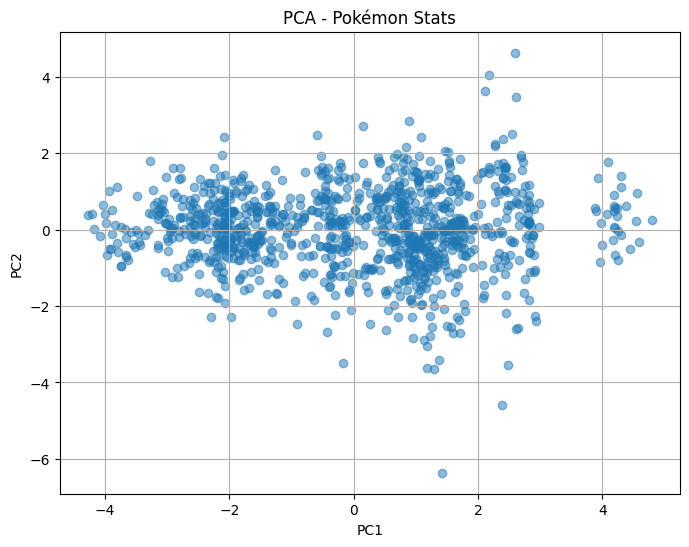

In [ ]:
# ==========================
# 5. PCA - Reducción de dimensionalidad
# ==========================
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_full)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], alpha=0.5)
plt.title("PCA - Pokémon Stats")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()



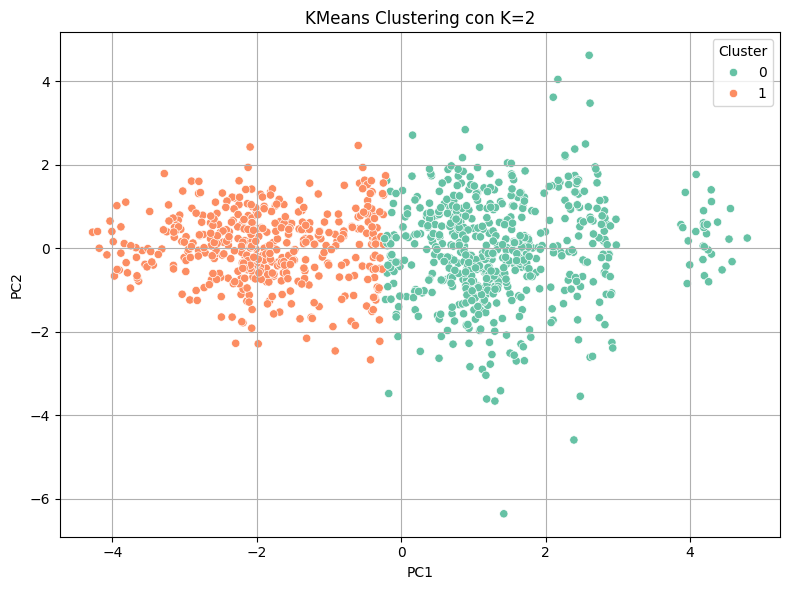

K=2 → Silhouette Score = 0.2707


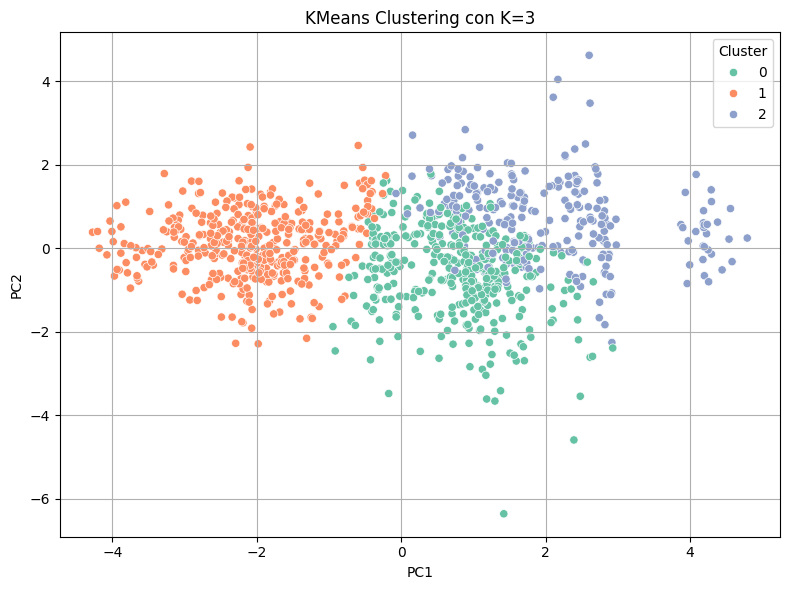

K=3 → Silhouette Score = 0.1963


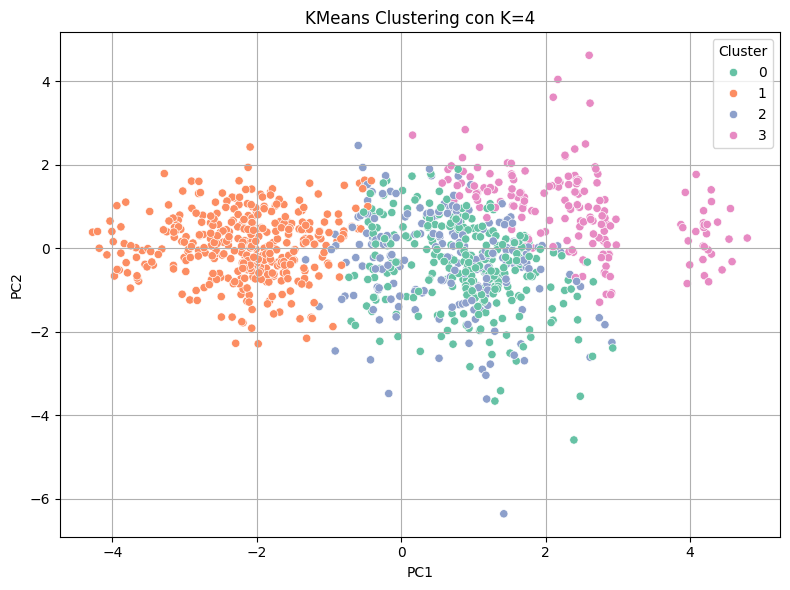

K=4 → Silhouette Score = 0.1892


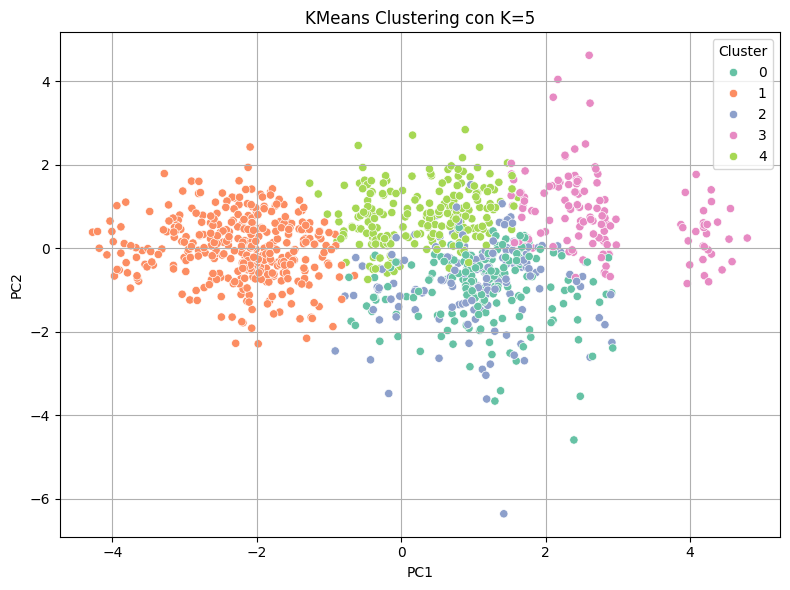

K=5 → Silhouette Score = 0.1715


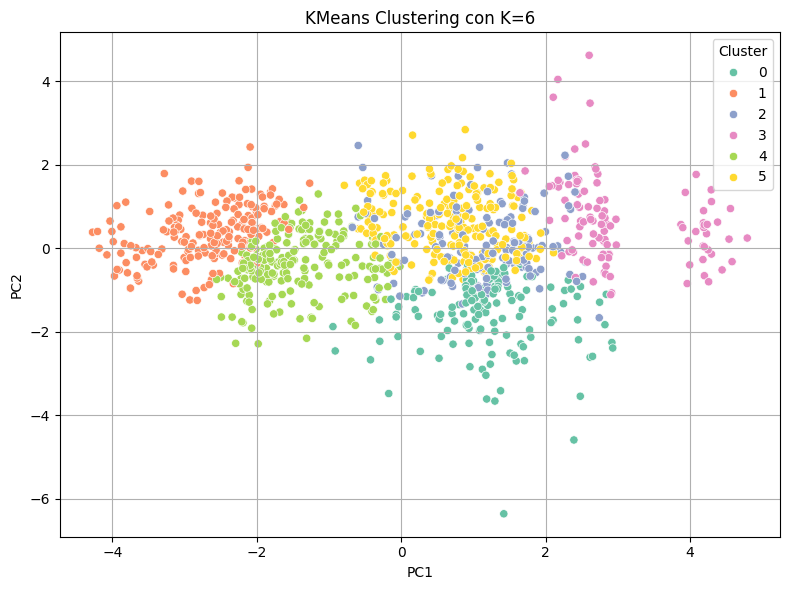

K=6 → Silhouette Score = 0.1072


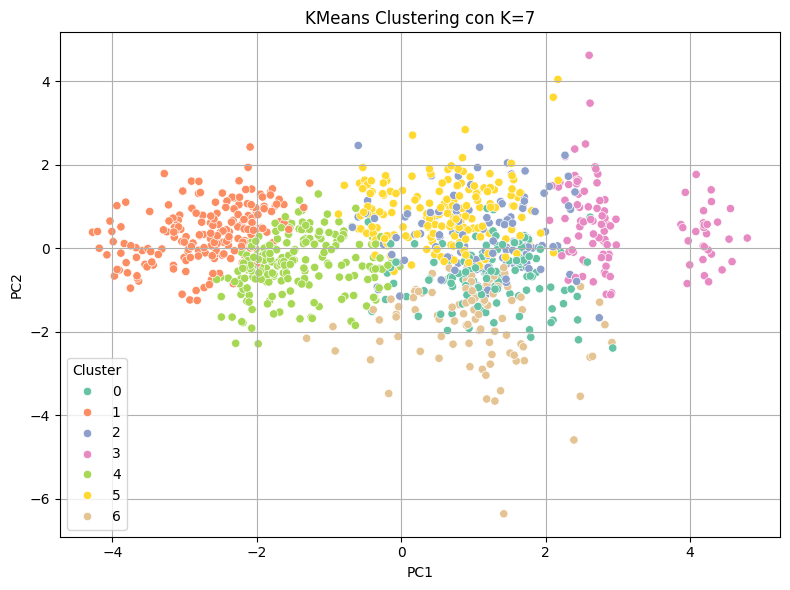

K=7 → Silhouette Score = 0.1095


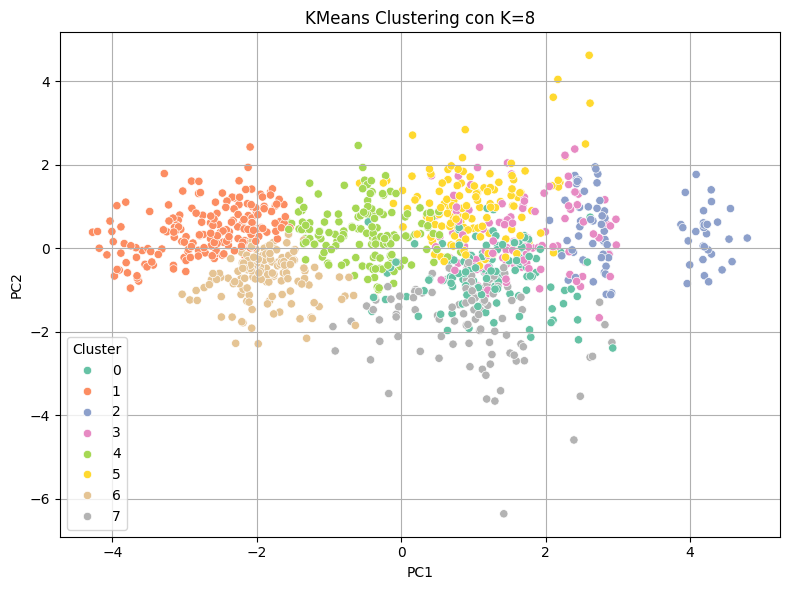

K=8 → Silhouette Score = 0.1027


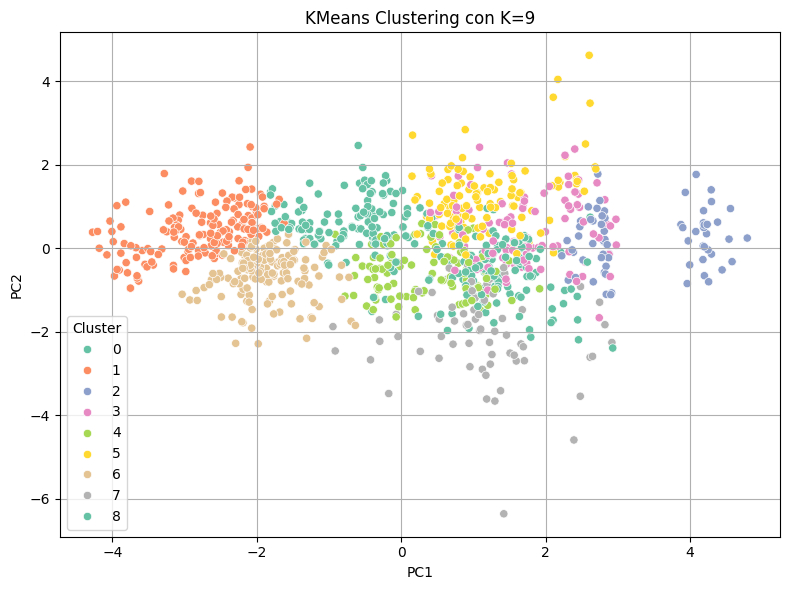

K=9 → Silhouette Score = 0.0923


In [ ]:
# ==========================
# 6. KMeans Clustering
# ==========================

df_base = df_clean.copy()
silhouette_scores = []

for k in range(2, 10):
    # Aplica KMeans con k clusters
    kmeans = KMeans(n_clusters=k, random_state=1545)
    clusters = kmeans.fit_predict(X_full)

    # Crea una copia temporal con los clusters para visualizar
    df_temp = df_base.copy()
    df_temp['Cluster'] = clusters
    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        x=X_pca[:, 0],
        y=X_pca[:, 1],
        hue=df_temp['Cluster'],
        palette='Set2',
        legend='full'
    )
    plt.title(f"KMeans Clustering con K={k}")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend(title="Cluster")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    score = silhouette_score(X_full, clusters)
    silhouette_scores.append(score)
    print(f"K={k} → Silhouette Score = {score:.4f}")

K=2 → Silhouette Score = 0.2707
K=3 → Silhouette Score = 0.1963
K=4 → Silhouette Score = 0.1892
K=5 → Silhouette Score = 0.1715
K=6 → Silhouette Score = 0.1072
K=7 → Silhouette Score = 0.1095
K=8 → Silhouette Score = 0.1027
K=9 → Silhouette Score = 0.0923


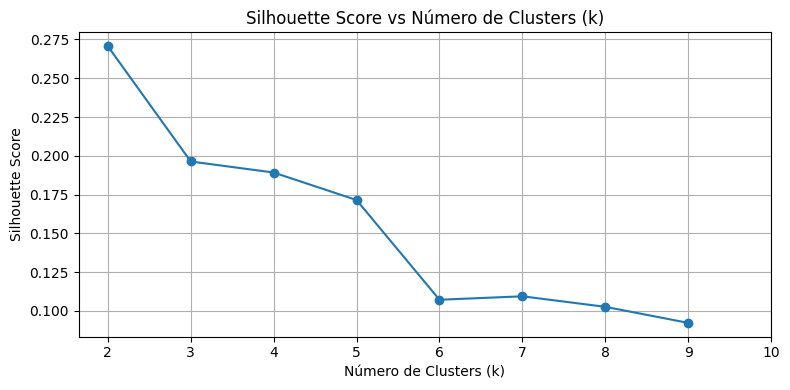

In [ ]:
# Graficamos los Silhoutte scores para tener una idea de cual k means es el optimo
silhouette_scores = []

# Probar valores de k desde 2 hasta 10
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=1545)
    clusters = kmeans.fit_predict(X_full)

    # Calcular el Silhouette Score
    score = silhouette_score(X_full, clusters)
    silhouette_scores.append(score)
    print(f"K={k} → Silhouette Score = {score:.4f}")

# Graficar los resultados
plt.figure(figsize=(8, 4))
plt.plot(range(2, 10), silhouette_scores, marker='o')
plt.title("Silhouette Score vs Número de Clusters (k)")
plt.xlabel("Número de Clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.xticks(range(2, 11))
plt.tight_layout()
plt.show()

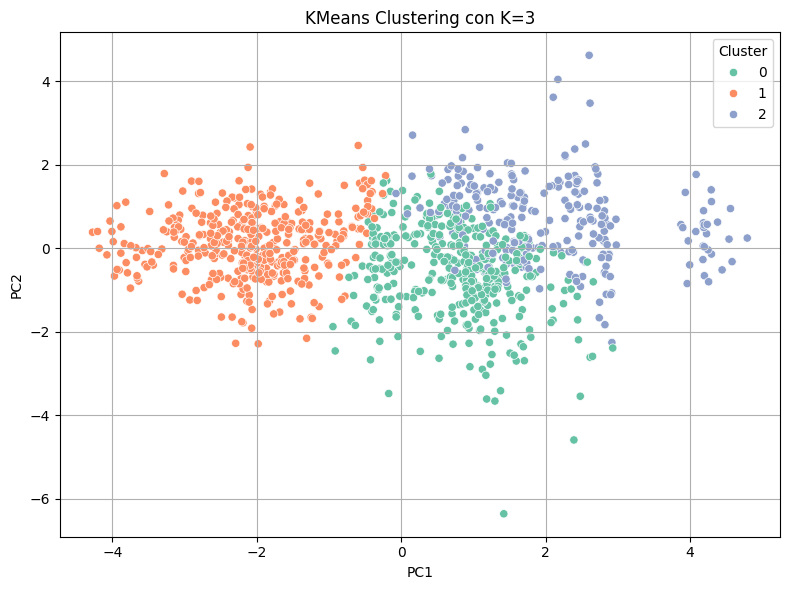

K=3 → Silhouette Score = 0.1963

Promedios por cluster:
              Total         HP     Attack    Defense     Sp._Atk    Sp._Def      Speed  Generation  Legendary
Cluster                                                                                                      
0        474.126005  81.536193  93.962466  90.278820   66.632708  77.552279  63.943700    4.777480   0.045576
1        308.145320  50.327586  54.337438  50.948276   50.064039  49.921182  52.613300    4.376847   0.007389
2        552.414545  84.370909  91.145455  82.010909  107.585455  91.905455  95.483636    5.236364   0.338182


In [ ]:
# Elejimos k=3
k = 3

# Aplica KMeans con k clusters
kmeans = KMeans(n_clusters=k, random_state=1545)
clusters = kmeans.fit_predict(X_full)

# Crea una copia temporal con los clusters para visualizar
df_temp = df_base.copy()
df_temp['Cluster'] = clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    hue=df_temp['Cluster'],
    palette='Set2',
    legend='full'
)
plt.title(f"KMeans Clustering con K={k}")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Cluster")
plt.grid(True)
plt.tight_layout()
plt.show()

score = silhouette_score(X_full, clusters)
silhouette_scores.append(score)
print(f"K={k} → Silhouette Score = {score:.4f}\n")

cluster_summary = df_temp.groupby('Cluster').mean(numeric_only=True)
print("Promedios por cluster:")
print(cluster_summary)

['Type_1', 'Type_2', 'Total', 'HP', 'Attack', 'Defense', 'Sp._Atk', 'Sp._Def', 'Speed', 'Generation', 'Legendary', 'Type_1', 'Type_2', 'Cluster']
*************************************************
Distribución de Type_1 por cluster:
Cluster    0   1   2
Type_1              
Bug       25  46  14
Dark      17  15  13
Dragon    10   9  20
Electric  11  22  32
Fairy      6  12  11
Fighting  22  12   6
Fire      16  24  26
Flying     3   3   4
Ghost     15  17  10
Grass     40  44  21
Ground    20  16   5
Ice        9  10  11
Normal    55  51  13
Poison    17  17   8
Psychic    7  24  34
Rock      30  19   9
Steel     17   9  11
Water     53  54  27
bug        0   1   0
ice        0   1   0
Legendary por cluster:
Legendary  False  True 
Cluster                
0            356     17
1            403      3
2            182     93
Distribución por generación:
Generation   1   2   3   4   5   6   7   8   9
Cluster                                       
0           51  39  50  40  53  22  39  

/tmp/ipython-input-33-1887747152.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_temp, x='Cluster', palette='Set2')


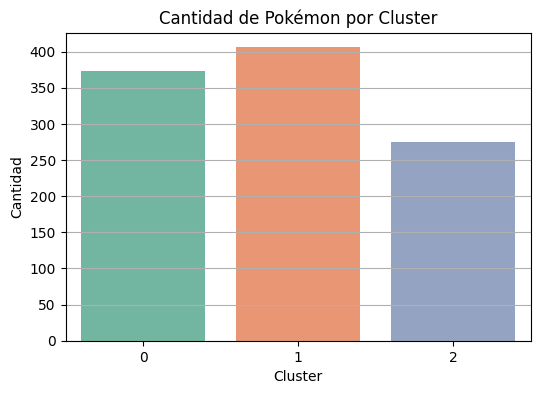

In [ ]:
print(df_temp.columns.tolist())
df_temp = df_temp.loc[:, ~df_temp.columns.duplicated()]
print("*************************************************")
type_distribution = pd.crosstab(df_temp['Type_1'], df_temp['Cluster'])
print("Distribución de Type_1 por cluster:")
print(type_distribution)

legendary_counts = pd.crosstab(df_temp['Cluster'], df_temp['Legendary'])
print("Legendary por cluster:")
print(legendary_counts)

generacion_dist = pd.crosstab(df_temp['Cluster'], df_temp['Generation'])
print("Distribución por generación:")
print(generacion_dist)

plt.figure(figsize=(6, 4))
sns.countplot(data=df_temp, x='Cluster', palette='Set2')
plt.title("Cantidad de Pokémon por Cluster")
plt.ylabel("Cantidad")
plt.grid(axis='y')
plt.show()


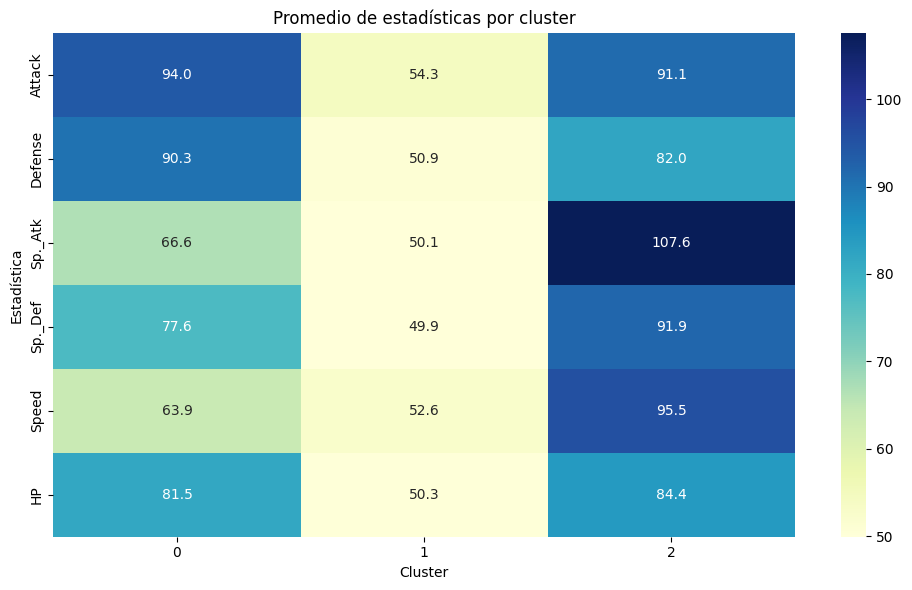

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Solo estadísticas relevantes
stats_cols = ['Attack', 'Defense', 'Sp._Atk', 'Sp._Def', 'Speed', 'HP']
mean_stats = df_temp.groupby('Cluster')[stats_cols].mean().T

# Gráfico comparativo
plt.figure(figsize=(10, 6))
sns.heatmap(mean_stats, annot=True, fmt=".1f", cmap='YlGnBu')
plt.title("Promedio de estadísticas por cluster")
plt.xlabel("Cluster")
plt.ylabel("Estadística")
plt.tight_layout()
plt.show()


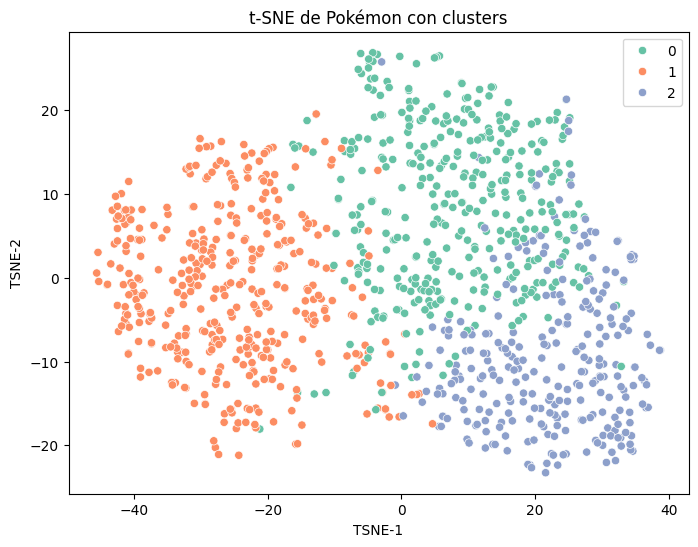

In [ ]:
# ==========================
# 7. t-SNE para visualización avanzada
# ==========================
tsne = TSNE(n_components=2, perplexity=40, random_state=1545)
X_tsne = tsne.fit_transform(X_full)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=clusters, palette='Set2')
plt.title("t-SNE de Pokémon con clusters")
plt.xlabel("TSNE-1")
plt.ylabel("TSNE-2")
plt.show()


In [ ]:
# Filtrar por tipo Dragón
df = df.loc[:, ~df.columns.duplicated()]
df_ori = df[(df['Type_1'] == 'Dragon') | (df['Type_2'] == 'Dragon')][stats_cols]
print(df_ori.info())
print("****")
print(df_ori.head())  # Muestra los primeros registros
print("****")
print(df_ori.describe())  # Muestra resumen estadístico

plt.show()

# Obtener todos los tipos únicos (asegúrate que estén en inglés como "Bug")

unique_types_raw = pd.unique(df[['Type_1', 'Type_2']].values.ravel())
unique_types = sorted(set(str(t).capitalize() for t in unique_types_raw if pd.notna(t)))

# Mostrar para confirmar qué tipos hay
print("Tipos encontrados:", unique_types)

# Diccionario para guardar varianzas por tipo
type_variances = {}
for poke_type in unique_types:
    # Normaliza las columnas de tipo en el DataFrame antes de comparar
    type_stats = df[
        (df['Type_1'].str.capitalize() == poke_type) |
        (df['Type_2'].str.capitalize() == poke_type)
    ][stats_cols]

    # Calcular Varianza
    type_variances[f"var_{poke_type.lower()}"] = type_stats.var()

# Convertir a DataFrame
variance_df = pd.DataFrame(type_variances).T

# Mostrar resultado
variance_df


<class 'pandas.core.frame.DataFrame'>
Index: 73 entries, 159 to 1100
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   Attack   73 non-null     int64
 1   Defense  73 non-null     int64
 2   Sp._Atk  73 non-null     int64
 3   Sp._Def  73 non-null     int64
 4   Speed    73 non-null     int64
 5   HP       73 non-null     int64
dtypes: int64(6)
memory usage: 4.0 KB
None
****
     Attack  Defense  Sp._Atk  Sp._Def  Speed  HP
159      64       45       50       50     50  41
160      84       65       70       70     70  61
161     134       95      100      100     80  91
249      95       95       95       95     85  75
360      70       50       50       50     70  50
****
           Attack     Defense     Sp._Atk     Sp._Def       Speed          HP
count   73.000000   73.000000   73.000000   73.000000   73.000000   73.000000
mean    96.547945   83.452055   88.452055   79.369863   79.000000   85.972603
std     28.494171   24.6

,Attack,Defense,Sp._Atk,Sp._Def,Speed,HP
var_bug,1075.101456,985.466293,879.578947,936.265845,983.074356,320.430011
var_dark,716.048861,645.628157,824.070600,620.961491,598.781781,831.644099
var_dragon,811.917808,607.584475,1238.278919,685.208524,800.388889,1132.360350
var_electric,765.966847,618.401081,891.247928,463.981982,1034.414414,555.869550
var_fairy,945.054563,794.225942,968.380952,1032.866815,1058.059276,567.833085
var_fighting,646.494414,630.360360,694.963243,542.243243,764.378378,554.745225
var_fire,691.895363,602.324149,825.049684,515.654923,623.086570,397.322493
var_flying,883.526782,548.130803,901.671868,674.822931,533.237463,445.172489
var_ghost,817.250381,1058.196728,1163.668950,785.406393,865.108067,814.086377
var_grass,761.998203,606.925436,589.855338,497.933769,719.359477,395.335076


In [ ]:
# Selecciona la varianza del tipo Dragon
dragon_variance = variance_df.loc["var_dragon"]

# Diccionario para guardar las comparaciones
variance_comparison = {}

# Comparar con cada otro tipo
for index, row in variance_df.iterrows():
    if index != "var_dragon":
        # Divide cada estadística: varianza_tipo / varianza_dragon
        comparison = row / dragon_variance
        variance_comparison[index] = comparison

# Convertir a DataFrame
comparison_df = pd.DataFrame(variance_comparison).T

# Mostrar resultado: cada valor indica si una estadística es más o menos variable que la del tipo Dragon
comparison_df


,Attack,Defense,Sp._Atk,Sp._Def,Speed,HP
var_bug,1.324151,1.621941,0.710324,1.366396,1.228246,0.282975
var_dark,0.881923,1.062615,0.665497,0.906237,0.748114,0.734434
var_electric,0.943404,1.017803,0.719747,0.677140,1.292390,0.490895
var_fairy,1.163978,1.307186,0.782038,1.507376,1.321931,0.501460
var_fighting,0.796256,1.037486,0.561233,0.791355,0.955009,0.489902
var_fire,0.852174,0.991342,0.666287,0.752552,0.778480,0.350880
var_flying,1.088197,0.902147,0.728165,0.984843,0.666223,0.393137
var_ghost,1.006568,1.741645,0.939747,1.146230,1.080860,0.718929
var_grass,0.938516,0.998915,0.476351,0.726689,0.898762,0.349125
var_ground,0.944072,1.782377,0.392687,0.667665,0.832531,0.635549


# **Aprendizaje Supervisado**

**Reglas de asociación**

Ver estadisticas mas altas a traves de tipos y relación de estadisticas con tipo

In [ ]:
# 1. Definir umbrales para considerar una estadística como "alta"
stat_thresholds = {
    'HP': 95,
    'Attack': 110,
    'Defense': 100,
    'Sp._Atk': 110,
    'Sp._Def': 100,
    'Speed': 105
}

# 2. Crear las etiquetas binarizadas
def build_attributes(row):
    tags = []

    # Tipos primario y secundario
    tags.append(f'Type_1={row["Type_1"]}')
    if pd.notna(row['Type_2']):
        tags.append(f'Type_2={row["Type_2"]}')

    # Etiquetas por estadísticas altas
    for stat, threshold in stat_thresholds.items():
        if row[stat] >= threshold:
            tags.append(f'High_{stat}')

    return tags

# 3. Aplicar función al dataframe
transactions = df.apply(build_attributes, axis=1).tolist()

# 4. Codificación one-hot
te = TransactionEncoder()
te_array = te.fit_transform(transactions)
df_encoded = pd.DataFrame(te_array, columns=te.columns_)

# 5. Apriori y reglas
frequent_itemsets = apriori(df_encoded, min_support=0.01, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.3)

# 6. Filtrar reglas donde antecedent sea tipo y el consecuente una estadística alta
filtered_rules = rules[
    rules['antecedents'].apply(lambda x: any(('Type_1=' in str(item) or 'Type_2=' in str(item)) for item in x)) &
    rules['consequents'].apply(lambda x: any('High_' in str(item) for item in x))
]
# 7. Mostrar reglas ordenadas por lift
filtered_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].sort_values(by='lift', ascending=False)


,antecedents,consequents,support,confidence,lift
20,(Type_2=Rock),(High_Defense),0.010436,0.687500,3.716026
18,(Type_1=Steel),(High_Defense),0.022770,0.648649,3.506029
21,(Type_2=Steel),(High_Defense),0.018027,0.593750,3.209295
8,(Type_2=Fighting),(High_Attack),0.017078,0.514286,2.945963
27,(Type_2=Dragon),(High_Sp._Atk),0.011385,0.352941,2.776119
7,(Type_2=Dark),(High_Attack),0.011385,0.480000,2.749565
5,(Type_1=Fighting),(High_Attack),0.018027,0.475000,2.720924
17,(Type_1=Rock),(High_Defense),0.027514,0.500000,2.702564
31,(Type_2=Psychic),(High_Sp._Def),0.015180,0.380952,2.541290
4,(Type_1=Dragon),(High_Attack),0.016129,0.435897,2.496934


In [ ]:
df_assoc = df.copy()

# Discretizar Attack y Speed en 'Low', 'Medium', 'High'
df_assoc['Attack_level'] = pd.qcut(df_assoc['Attack'], q=3, labels=['Low', 'Medium', 'High'])
df_assoc['Speed_level'] = pd.qcut(df_assoc['Speed'], q=3, labels=['Low', 'Medium', 'High'])

# Convertir Legendary y Generation a string categórica
df_assoc['Legendary_str'] = df_assoc['Legendary'].astype(str)
df_assoc['Generation_str'] = 'Gen_' + df_assoc['Generation'].astype(str)

# Armar lista de características por fila
df_assoc['Attributes'] = df_assoc.apply(
    lambda row: [
        f"Attack_{row['Attack_level']}",
        f"Speed_{row['Speed_level']}",
        f"Legendary_{row['Legendary_str']}",
        f"{row['Generation_str']}"
    ],
    axis=1
)

# Convertir a transacciones
transactions = df_assoc['Attributes'].tolist()

te = TransactionEncoder()
te_array = te.fit_transform(transactions)
df_encoded = pd.DataFrame(te_array, columns=te.columns_)

from mlxtend.frequent_patterns import apriori, association_rules

frequent_itemsets = apriori(df_encoded, min_support=0.05, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.6)

# Filtrar reglas con confianza alta y que involucren "Legendary" o "Attack"
filtered_rules = rules[
    rules['antecedents'].astype(str).str.contains("Attack_|Speed_|Legendary_|Gen_") |
    rules['consequents'].astype(str).str.contains("Attack_|Speed_|Legendary_|Gen_")
]

# Ordenar por lift
filtered_rules = filtered_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].sort_values(by='lift', ascending=False)

filtered_rules.head(20)


,antecedents,consequents,support,confidence,lift
20,"(Attack_High, Legendary_1)",(Speed_High),0.055977,0.756410,2.344872
16,(Legendary_1),(Speed_High),0.078748,0.734513,2.276991
21,"(Speed_High, Legendary_1)",(Attack_High),0.055977,0.710843,2.263531
1,(Legendary_1),(Attack_High),0.074004,0.690265,2.198006
32,"(Speed_Medium, Gen_5)",(Legendary_0),0.056926,1.000000,1.120085
25,"(Speed_Medium, Attack_Low)",(Legendary_0),0.117647,1.000000,1.120085
22,"(Gen_1, Attack_Low)",(Legendary_0),0.053131,1.000000,1.120085
31,"(Speed_Medium, Gen_3)",(Legendary_0),0.050285,1.000000,1.120085
30,"(Gen_1, Speed_Medium)",(Legendary_0),0.052182,1.000000,1.120085
2,(Attack_Low),(Legendary_0),0.330171,0.988636,1.107357


RandomForestClassifier:
modelo para predecir si es legendario

In [ ]:
# 1. Regenerar codificación de tipos (dummy)
type1_dummies = pd.get_dummies(df['Type_1'], prefix='T1')
type2_dummies = pd.get_dummies(df['Type_2'], prefix='T2')

# Asegura coherencia de nombres (capitaliza todos)
type1_dummies.columns = [col.capitalize() for col in type1_dummies.columns]
type2_dummies.columns = [col.capitalize() for col in type2_dummies.columns]

# 2. Concatenar con df
df_full = pd.concat([df, type1_dummies, type2_dummies], axis=1)

# 3. Definir variables predictoras y target
features = stats_cols + list(type1_dummies.columns) + list(type2_dummies.columns)
X = df_full[features]
y = df_full['Legendary']

# 4. División de datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1545)

# 5. Entrenar modelo
clf = RandomForestClassifier(n_estimators=1000, random_state=1545)
clf.fit(X_train, y_train)

# 6. Predicción y evaluación
y_pred = clf.predict(X_test)

print("=== Accuracy ===")
print(accuracy_score(y_test, y_pred))

print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred))

print("\n=== Matriz de Confusión ===")
print(confusion_matrix(y_test, y_pred))

=== Accuracy ===
0.9022082018927445

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.90      1.00      0.95       276
           1       1.00      0.24      0.39        41

    accuracy                           0.90       317
   macro avg       0.95      0.62      0.67       317
weighted avg       0.91      0.90      0.88       317


=== Matriz de Confusión ===
[[276   0]
 [ 31  10]]


Hipotesis

In [ ]:
# ==============================
# 8. Análisis de hipótesis
# ==============================
hypothesis_results = {}
df = df.loc[:, ~df.columns.duplicated()]

# Hipótesis 1: Balance en Pokémon duales //Los Pokémon con doble tipo tienden a distribuirse en clusters con mayor balance estadístico entre defensa y ataque que los de tipo único
df['Dual_Type'] = df['Type_2'] != 'None'
df['Attack_Def_Balance'] = abs(df['Attack'] - df['Defense']) + abs(df['Sp._Atk'] - df['Sp._Def'])
balance_dual = df.groupby('Dual_Type')['Attack_Def_Balance'].mean()
hypothesis_results['H1: Balance en Pokémon duales'] = balance_dual

# Hipótesis 2: Velocidad alta = bajo HP y Defensa // Pokémon rápidos (alta Velocidad) forman un grupo estadísticamente diferenciado que sacrifica HP y Defensa para favorecer ofensiva
median_speed = df['Speed'].median()
high_speed = df[df['Speed'] > median_speed]
low_speed = df[df['Speed'] <= median_speed]
hypothesis_results['H2: Velocidad alta = bajo HP y Defensa'] = {
    'High_Speed': high_speed[['HP', 'Defense']].mean(),
    'Low_Speed': low_speed[['HP', 'Defense']].mean()
}

# Hipótesis 3: Arquetipos ofensivos y defensivos // Existe una separación clara entre arquetipos ofensivos y defensivos en el espacio estadístico multidimensional
df['Offensive_Sum'] = df['Attack'] + df['Sp._Atk']
df['Defensive_Sum'] = df['Defense'] + df['Sp._Def']
pca_stats = PCA(n_components=1).fit_transform(df[['Offensive_Sum', 'Defensive_Sum']])
df['OffDef_PC1'] = pca_stats
hypothesis_results['H3: Arquetipos ofensivos y defensivos'] = df['OffDef_PC1'].describe()

# Hipótesis 4: Generación y agresividad // Ciertas generaciones (especialmente posteriores a la 6ta) tienen una densidad mayor de Pokémon con perfiles de alta velocidad y ofensiva combinada
df['Gen_Category'] = df['Generation'].apply(lambda x: 'Recent' if x >= 6 else 'Old')
gen_stats = df.groupby('Gen_Category')[['Speed', 'Offensive_Sum']].mean()
hypothesis_results['H4: Generación y agresividad'] = gen_stats

# Hipótesis 5: Homogeneidad del tipo Dragón // El tipo Dragón presenta mayor homogeneidad interna en el espacio estadístico (menor dispersión entre individuos del mismo tipo)

df = df.loc[:, ~df.columns.duplicated()]
dragon_stats = df[(df['Type_1'] == 'Dragon') | (df['Type_2'] == 'Dragon')][stats_cols]
hypothesis_results['H5: Homogeneidad del tipo Dragón'] = dragon_stats.var()

# Hipótesis 6: Psíquico vs Fantasma // Los Pokémon de tipo Fantasma y Psíquico forman grupos estadísticamente similares, diferenciándose de otros tipos por su alta defensa especial y velocidad media-alta
ghost_psychic = df[
    (df['Type_1'].isin(['Ghost', 'Psychic'])) |
    (df['Type_2'].isin(['Ghost', 'Psychic']))
]
gp_group = ghost_psychic.groupby('Type_1')[['Sp._Def', 'Speed']].mean()
gp_filtered = gp_group.loc[gp_group.index.isin(['Ghost', 'Psychic'])]

hypothesis_results['H6: Psíquico vs Fantasma'] = gp_filtered


# Hipótesis 7: Total similar, pero stats distintos por generación //  Pokémon de generaciones antiguas (1-5) y recientes (6+) presentan patrones de clustering distintos incluso si tienen valores totales similares, por su distribución interna de stats
recent = df[df['Generation'] >= 6][stats_cols]
old = df[df['Generation'] < 6][stats_cols]
hypothesis_results['H7: Total similar, pero stats distintos por generación'] = {
    'Old': old.mean(),
    'Recent': recent.mean()
}

# ==============================
# 9. Mostrar resultados
# ==============================
# Mostrar resumen
for name, result in hypothesis_results.items():
    print(f"\n\n=== {name} ===")
    print(result)




=== H1: Balance en Pokémon duales ===
Dual_Type
True    44.405123
Name: Attack_Def_Balance, dtype: float64


=== H2: Velocidad alta = bajo HP y Defensa ===
{'High_Speed': HP         74.690196
Defense    74.660784
dtype: float64, 'Low_Speed': HP         66.095588
Defense    71.387868
dtype: float64}


=== H3: Arquetipos ofensivos y defensivos ===
count    1.054000e+03
mean     6.471736e-15
std      5.969207e+01
min     -1.431967e+02
25%     -5.017065e+01
50%      5.152843e+00
75%      4.762806e+01
max      1.606091e+02
Name: OffDef_PC1, dtype: float64


=== H4: Generación y agresividad ===
                  Speed  Offensive_Sum
Gen_Category                          
Old           66.642750     145.451420
Recent        69.833766     154.890909


=== H5: Homogeneidad del tipo Dragón ===
Attack      811.917808
Defense     607.584475
Sp._Atk    1238.278919
Sp._Def     685.208524
Speed       800.388889
HP         1132.360350
dtype: float64


=== H6: Psíquico vs Fantasma ===
           Sp._